In [2]:
from collections import defaultdict
import functools
import io
import os
import os.path as osp

from attrdict import AttrDict
import xml.etree.cElementTree as ElementTree

import numpy as np
import sonnet as snt
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
% matplotlib inline

from PIL import Image

In [73]:
def parse_object(obj):
    """Extracts object properties from an xml node representing an object."""
    id = int(obj[0].text)
    x2, x1, y2, y1 = (int(i.text) for i in obj[2])
    bbox = np.asarray([y1, x1, y2 - y1, x2 - x1])

    return id, dict(name=obj[1].text, bbox=bbox, occluded=int(obj[3].text), generated=int(obj[4].text))


def parse_label(label_path):
    """Parses an xml label file."""
    root = ElementTree.parse(label_path).getroot()

    folder = root[0].text
    filename = root[1].text
    size = tuple(int(i.text) for i in reversed(root[3]))

    obj_by_id = dict()
    objects = root[4:]
    for obj in objects:
        id, obj = parse_object(obj)
        obj_by_id[id] = obj

    return folder, filename, size, obj_by_id


def find_xmls(path):
    """Finds all xml files in a path."""
    xmls = sorted([p for p in os.listdir(path) if p.endswith('.xml')])
    return [os.path.join(path, xml) for xml in xmls]


def parse_label_seq(seq_path, fixed_size=None):
    """Parses xml labels for a given sequence and potentially adjusts bbox size.
    
    Args:
        seq_path: string, path to a folder with xmls for a single sequence.
        
    Returns:
        tuple of ({folder: file_list}, {obj_id: properties})
    """
    xmls = find_xmls(seq_path)

    obj_by_id = dict()
    imgs_by_folder = defaultdict(list)

    for p in xmls:
        folder, filename, size, by_id = parse_label(p)

        # figure out how to scale the bounding box to reflect new image size
        if fixed_size:
            size_ratio = np.asarray(fixed_size).astype(np.float32) / np.asarray(size)
            size_ratio = np.tile(size_ratio, (2,))
            size = fixed_size
        else:
            size_ratio = 1.

        imgs_by_folder[folder].append(dict(filename=filename, size=size))

        for i, obj in by_id.iteritems():

            if i not in obj_by_id:
                obj_by_id[i] = AttrDict()
                obj_by_id[i].id = i
                obj_by_id[i].name = obj['name']
                obj_by_id[i]['boxes'] = []

            obj = AttrDict(obj)
            del obj['name']
            # scale the bounding box
            obj.bbox = obj.bbox * size_ratio
            obj.frame_num = int(filename)
            obj_by_id[i]['boxes'].append(obj)


    return imgs_by_folder, obj_by_id

In [100]:
def extract_files(filedict):
    """Extracts a sorted list of files from a {folder: file_list} dict for a single seq.
    """

    files = []
    dirnames = sorted(filedict.keys(), key=lambda x: int(x.split('_')[-1]))
    for dirname in dirnames:
        filelist = filedict[dirname]
        filelist = [d['filename'] for d in filelist]
        filelist = sorted(filelist, key=lambda x: int(x.split('.')[0]))
        for f in filelist:
            files.append(osp.join(dirname, f) + '.JPEG')

    return files

def extract_properties(filedict, properties, root_dir=None):
    """Extracts properties from an {obj_id: properties} dict and converts them to
    numpy arrays.
    """

    img_files = extract_files(filedict)
    if root_dir is not None:
        img_files = [osp.join(root_dir, f) for f in img_files]
        
    n_obj = len(properties)
    num_frames = len(img_files)

    obj_to_idx = dict(zip(properties.keys(), range(n_obj)))

    boxes = np.zeros([num_frames, n_obj, 4], dtype=np.float32)
    generated = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)
    occluded = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)
    presence = np.zeros([num_frames, n_obj, 1], dtype=np.uint8)

    for obj_id in properties.keys():
        obj_idx = obj_to_idx[obj_id]
        for box in properties[obj_id].boxes:
            frame_num = box.frame_num
            boxes[frame_num, obj_idx, :] = box.bbox
            generated[frame_num, obj_idx] = box.generated
            occluded[frame_num, obj_idx] = box.occluded
            presence[frame_num, obj_idx] = 1
        
    return AttrDict(boxes=boxes, generated=generated, occluded=occluded,
                    presence=presence, n_obj=n_obj, img_files=img_files)


In [112]:
def parse(sequence_list, annotations_root_dir=None, video_root_dir=None, 
          img_size=None, seq_filter=None):
    """Parses a list of sequences."""
    
    parsed_seqs = []
    for seq in sequence_list:
        dirname = os.path.dirname(seq)
        if root_dir is not None:
            dirname = osp.join(annotations_root_dir, dirname)
            
        parsed_seqs.append(parse_label_seq(dirname, fixed_size=img_size))
        
    parsed_seqs = np.asarray(parsed_seqs)
    if seq_filter is not None:
        parsed_seqs = seq_filter(parsed_seqs)
        
    seq_properties = []
    for parsed_seq in parsed_seqs:
        properties = extract_properties(*parsed_seq, root_dir=video_root_dir)
        seq_properties.append(properties)
        
    return np.asarray(seq_properties)

In [113]:
size = (480, 640)
seq_file = '/Users/adam/data/ILSVRC2015_VID/Annotations/VID/seqs.txt'
annotations_root_dir = '/Users/adam/data/ILSVRC2015_VID/Annotations/VID'
video_root_dir = '/Users/adam/data/ILSVRC2015_VID/Data/VID/train'

In [114]:
sequence_list = [line.strip() for line in open(seq_file)][:10]

In [115]:
parsed_seqs = parse(sequence_list, annotations_root_dir, video_root_dir, img_size=size)

In [116]:
sequence_list

['./train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00000000/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001000/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001001/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001002/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001003/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001004/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001005/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001006/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001007/000000.xml',
 './train/ILSVRC2015_VID_train_0000/ILSVRC2015_train_00001008/000000.xml']

In [117]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature_list(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [128]:
def read_img_as_bytes(path, img_size=None):
    buffer = io.BytesIO()
    img = Image.open(path)
    
    if img_size is not None:
        img = img.resize(reversed(img_size))
    
    img.save(buffer, format='JPEG')
    return buffer.getvalue()


def video_example(properties, img_size=None):
    
    img_files = list(properties.img_files)
    
    img_shape = np.asarray(Image.open(img_files[0])).shape
    if img_size is None:
        img_string = [open(f, 'rb').read() for f in img_files]
        
    else:
        img_string = [read_img_as_bytes(f, img_size) for f in img_files]
        img_shape = list(img_size) + [img_shape[-1]]
        
    feature = {
        'height': _int64_feature(img_shape[0]),
        'width': _int64_feature(img_shape[1]),
        'depth': _int64_feature(img_shape[2]),
        'num_frames': _int64_feature(len(img_files)),
        'frames_raw': _bytes_feature_list(img_string),
        'n_obj': _int64_feature(properties.n_obj)
    }
    
    for k in 'boxes generated occluded presence'.split():
        feature[k] = _bytes_feature_list(properties[k].tobytes())

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [129]:
def save_seqs_as_tfrecords(seq_list, tfrecords_file, img_size=None):
    with tf.python_io.TFRecordWriter(tfrecords_file) as writer:
        for seq_props in seq_list:
            vid = video_example(seq_props, img_size)
            vid_string = vid.SerializeToString()
            writer.write(vid_string)

In [130]:
save_seqs_as_tfrecords(parsed_seqs, 'videos.tfrecords', img_size=size)

In [131]:
!ls

images.tfrecords  imagnet_vid.ipynb videos.tfrecords


In [139]:
raw_image_dataset = tf.data.TFRecordDataset('videos.tfrecords')

# Create a dictionary describing the features.  
image_feature_description = {
    'height': tf.FixedLenFeature([], tf.int64),
    'width': tf.FixedLenFeature([], tf.int64),
    'depth': tf.FixedLenFeature([], tf.int64),
    'num_frames': tf.FixedLenFeature([], tf.int64),
    'frames_raw': tf.VarLenFeature(tf.string),
    'n_obj': tf.FixedLenFeature([], tf.int64),
    'boxes': tf.VarLenFeature(tf.string),
    'generated': tf.VarLenFeature(tf.string),
    'occluded': tf.VarLenFeature(tf.string),
    'presence': tf.VarLenFeature(tf.string),
}

# SEQ_NUM_FRAMES = 100
# EVERY_N_FRAMES = 2
# shape = (SEQ_NUM_FRAMES / EVERY_N_FRAMES, 360, 540, 3)

shape = (None, size[0], size[1], 3)
MAX_N_OBJECTS = 30


def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    d = tf.parse_single_example(example_proto, image_feature_description)
    
#     def map_func(idx):
#         return tf.io.decode_jpeg(d['frames_raw'].values[idx])
    
#     random_offset = tf.random_uniform(
#         shape=(), minval=0,
#         maxval=d['num_frames'] - SEQ_NUM_FRAMES, dtype=tf.int64)

#     offsets = tf.range(random_offset, random_offset + SEQ_NUM_FRAMES, EVERY_N_FRAMES)
    
#     img = tf.map_fn(map_func, offsets, dtype=tf.uint8)
    
    img = tf.map_fn(tf.io.decode_jpeg, d['frames_raw'].values, dtype=tf.uint8)
    img.set_shape(shape)
    d['frames'] = img
    del d['frames_raw']
    
    n_obj = d['n_obj']
    num_frames = d['num_frames']
    _shape = [num_frames, n_obj]
    
    # different sequences will have different number of objects;
    # here we make sure that they are padded accordingly
    n_pads = MAX_N_OBJECTS - n_obj
    
    def _decode(name, dtype, n_elems):
        encoded = d[name].values
        
        # tensor consists of strings of length 1, but we need 4 bytes for a float32
        # we need to merge 4 strings into one along the last axis
        if dtype == tf.float32:
            encoded = tf.reshape(encoded, [-1, 4])
            encoded = tf.unstack(encoded, axis=-1)
            encoded = tf.strings.join(encoded)
        
        decoded = tf.reshape(tf.decode_raw(encoded, dtype), _shape + [n_elems])
        decoded = tf.pad(decoded, [(0, 0), (0, n_pads), (0, 0)])
        d[name] = decoded
    
    _decode('occluded', tf.uint8, 1)
    _decode('generated', tf.uint8, 1)
    _decode('presence', tf.uint8, 1)
    _decode('boxes', tf.float32, 4)
    
    return d

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

In [149]:
import sys
sys.path.append('/Users/adam/data/imgnet_vid_tracking')

In [150]:
from tf_imagenet_vid.dataset import Dataset

In [151]:
ds = Dataset('new_vid.tfrecords', list(size) + [3], max_n_objects=10)

In [152]:
parsed_image_dataset = ds()

In [153]:
it = parsed_image_dataset.repeat().make_one_shot_iterator()

In [154]:
batch = it.get_next()

In [155]:
batch

{'boxes': <tf.Tensor 'IteratorGetNext_2:0' shape=(?, ?, 4) dtype=float32>,
 'depth': <tf.Tensor 'IteratorGetNext_2:1' shape=() dtype=int64>,
 'frames': <tf.Tensor 'IteratorGetNext_2:2' shape=(?, 480, 640, 3) dtype=uint8>,
 'generated': <tf.Tensor 'IteratorGetNext_2:3' shape=(?, ?, 1) dtype=uint8>,
 'height': <tf.Tensor 'IteratorGetNext_2:4' shape=() dtype=int64>,
 'n_obj': <tf.Tensor 'IteratorGetNext_2:5' shape=() dtype=int64>,
 'num_frames': <tf.Tensor 'IteratorGetNext_2:6' shape=() dtype=int64>,
 'occluded': <tf.Tensor 'IteratorGetNext_2:7' shape=(?, ?, 1) dtype=uint8>,
 'presence': <tf.Tensor 'IteratorGetNext_2:8' shape=(?, ?, 1) dtype=uint8>,
 'width': <tf.Tensor 'IteratorGetNext_2:9' shape=() dtype=int64>}

In [156]:
sess = tf.Session()

In [157]:
res = sess.run(batch)

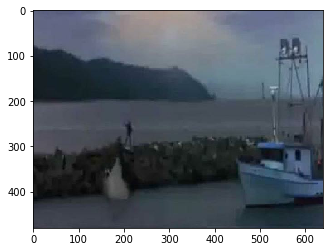

In [158]:
plt.imshow(res['frames'][9])

In [159]:
list(res['boxes'])

[array([[338.66666 , 153.33333 ,  81.333336,  74.666664],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ]], dtype=float32),
 array([[340.      , 153.33333 ,  80.      ,  73.333336],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      ],
        [  0.      ,   0.      ,   0.      ,   0.      

In [147]:
properties.boxes

NameError: name 'properties' is not defined